In [1]:
import time

import torch
import pandas as pd
import numpy as np
import cv2
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import imgaug as ia
import imgaug.augmenters as iaa



from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from PIL import Image
import os
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


import torch.nn
from torch import nn
# from torchvision.models import resnet50, ResNet50_Weights

In [2]:
csv_path = "/Users/tingshuoliang/Downloads/CNN_test/animal-clef-2025/metadata.csv"
data_root = "/Users/tingshuoliang/Downloads/CNN_test/animal-clef-2025"
querying_class_paths = {
    "SeaTurtle_Query": "images/SeaTurtleID2022/query/images",
    "Lynxs_Query": "images/LynxID2025/query",
    "Salamanders_Query": "images/SalamanderID2025/query/images"
}
training_class_paths = {
    "SeaTurtle_Data": "images/SeaTurtleID2022/database/turtles-data/data/images",
    "Lynxs_Data": "images/LynxID2025/database",
    "Salamanders_Data": "images/SalamanderID2025/database/images"
}

In [3]:
df = pd.read_csv(csv_path)
df.head()

,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025


In [4]:
class AnimalDataset(Dataset):
    def __init__(self, csv_file, root_dir, class_paths, transform=None):
        # external
        self.data = csv_file
        self.root_dir = root_dir
        self.class_paths = class_paths
        self.transform = transform

        # internal
        self.identities = self.data['identity'].unique()
        self.identity_to_label = {identity: idx for idx, identity in enumerate(self.identities)}
        
        self.orientations = self.data['orientation'].unique()
        self.orientation_to_label = {orientation: idx for idx, orientation in enumerate(self.orientations)}

        self.filtered_data = []
        for _, row in self.data.iterrows():
            for class_name, class_path in class_paths.items():
                if row['path'].startswith(class_path):
                    self.filtered_data.append({
                        'image_path': row['path'],
                        'identity': row['identity'],
                        'class': class_name,
                        'orientation': row['orientation']
                    })
                    break

    def __len__(self):
        return len(self.filtered_data)

    def __getitem__(self, idx):
        img_info = self.filtered_data[idx]
        img_path = os.path.join(self.root_dir, img_info['image_path'])

        image = Image.open(img_path).convert('RGB')
        identity_label = self.identity_to_label[img_info['identity']]
        class_label = list(self.class_paths.keys()).index(img_info['class'])
        orientation_label = self.orientation_to_label[img_info['orientation']]

        if self.transform:
            image = self.transform(image)

        return image, identity_label, class_label, orientation_label

In [5]:
Basic_Transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor()
])

In [6]:
Training_dataset = AnimalDataset(csv_file=df, root_dir=data_root, class_paths=training_class_paths, transform=Basic_Transform)
len(Training_dataset)

13074

In [7]:
Querying_dataset = AnimalDataset(csv_file=df, root_dir=data_root, class_paths=querying_class_paths, transform=Basic_Transform)
len(Querying_dataset)

2135

In [8]:
initLoader = DataLoader(Training_dataset, batch_size=64, shuffle=False, drop_last=False)

In [9]:
# writer = SummaryWriter(log_dir='ori_que_pics')
# step = 0
# for data in initLoader:
#     image, identity_label, class_label, orientation_label = data
#     writer.add_images("image", image, step)
#     print(f"Step {step} written successfully.")
#     step += 1
#     
# writer.close()

In [10]:
def firstBatchSamplePlot(theDataloader, theDataset):
    # only the first batch for display
    for data in theDataloader:
        images, identity_labels, _, orientation_labels = data
        break
        
    # reverse dic
    label_to_identity = {v: k for k, v in theDataset.identity_to_label.items()}
    label_to_orientation = {v: k for k, v in theDataset.orientation_to_label.items()}
    
    images = images.numpy()
    
    fig = plt.figure(figsize=(20, 20))
    rows, cols = 8, 8
    
    for i in range(min(64, len(images))):
        ax = fig.add_subplot(rows, cols, i+1)
    
        # if CHW to HWC
        if images.shape[1] == 1 or images.shape[1] == 3:
            img = np.transpose(images[i], (1, 2, 0))
        else:
            img = images[i]
    
        identity = label_to_identity[identity_labels[i].item()]
        orientation = label_to_orientation[orientation_labels[i].item()]
    
    
        ax.imshow(img)
        ax.set_title(f"ID: {identity}\nOri: {orientation}", fontsize=8)
        ax.axis('off')

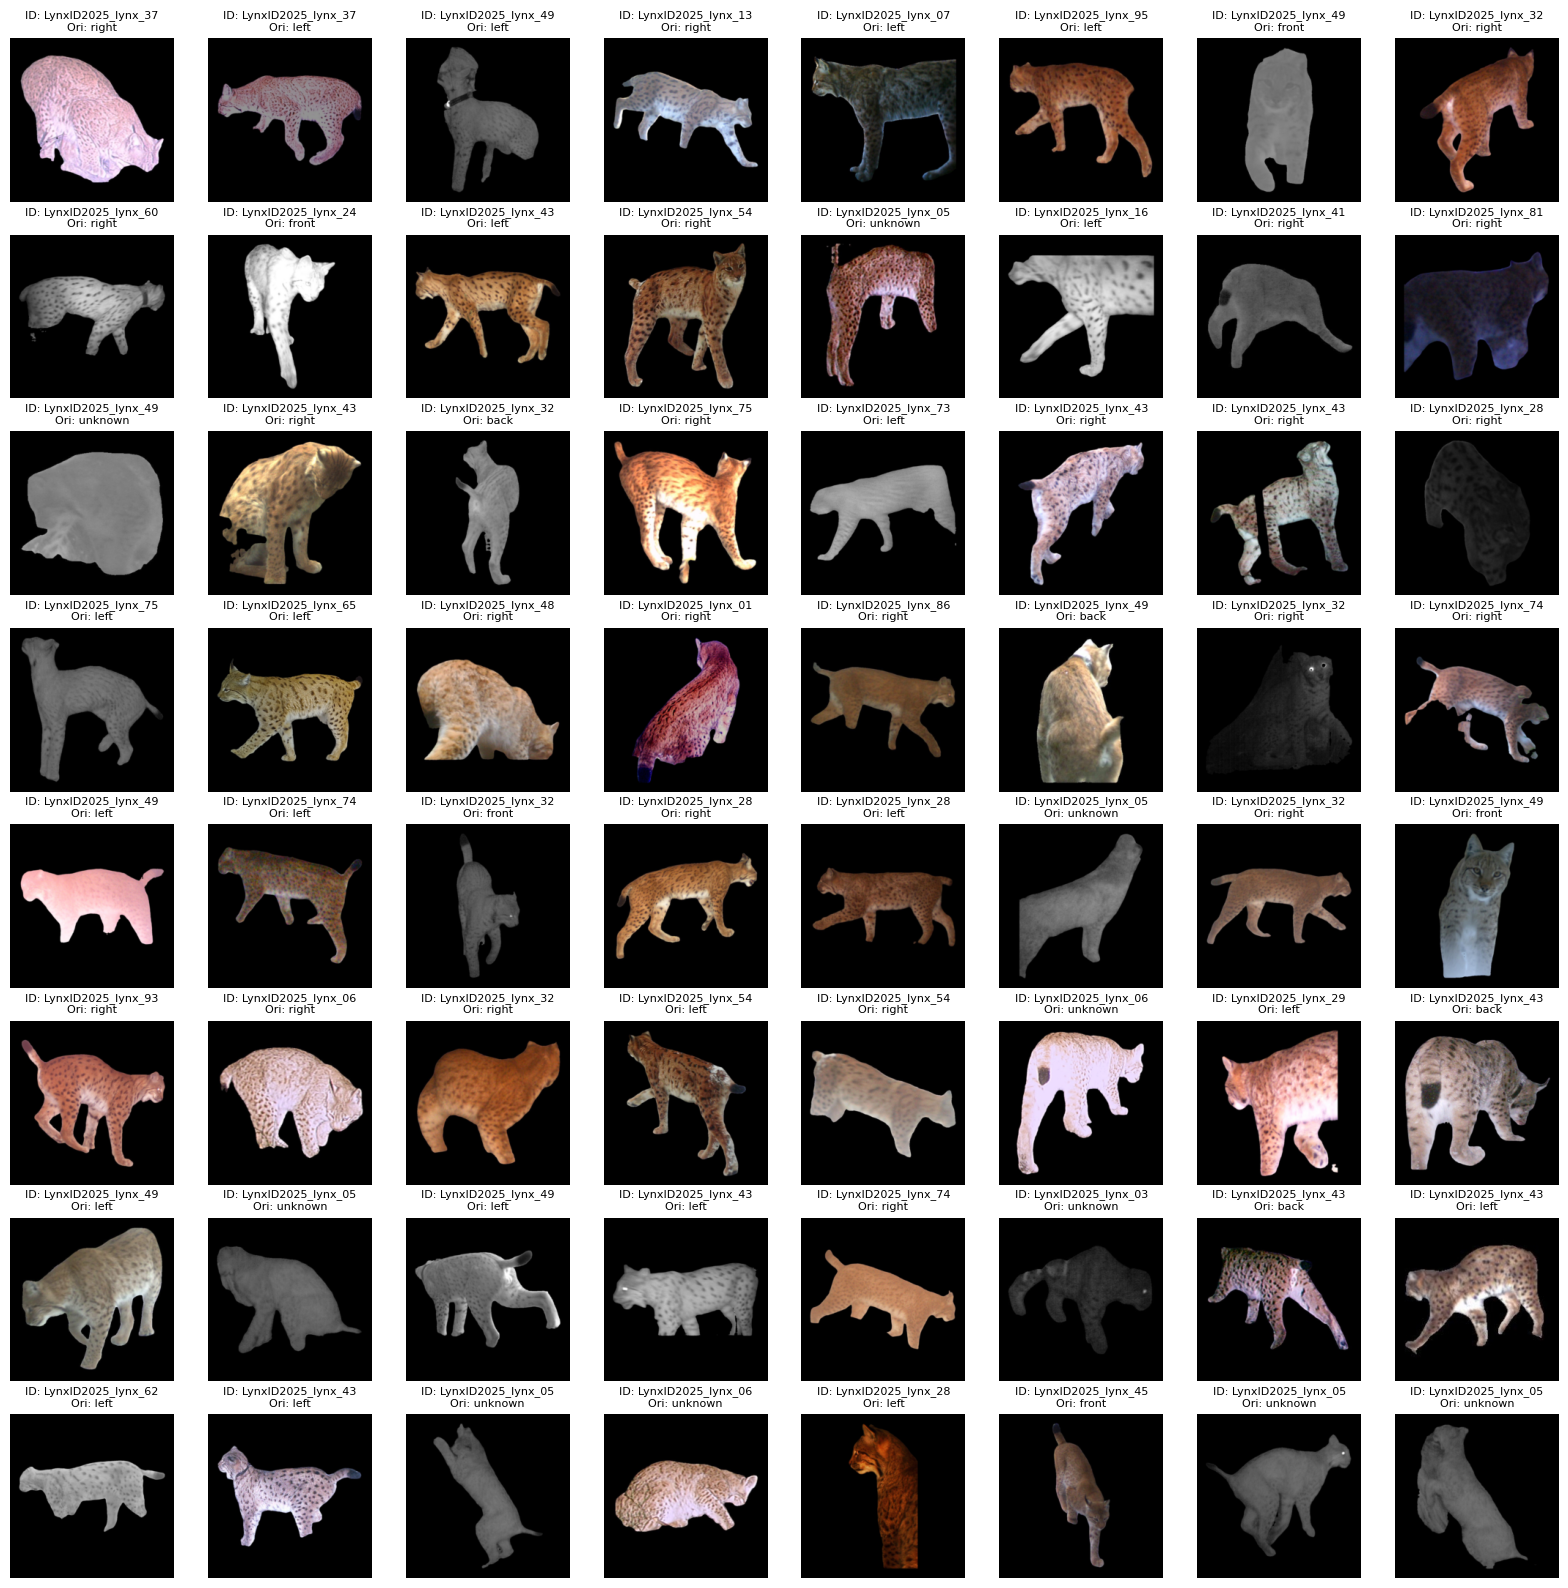

In [11]:
firstBatchSamplePlot(initLoader, Training_dataset)

In [12]:
# provided by imgaug document
basicAug = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

In [13]:
EgAug = iaa.Sequential([
    # 水平翻转
    iaa.Fliplr(0.5),
    
    # 裁剪
    iaa.Crop(percent=(0.1, 0.3)),
    
    # 颜色
    iaa.MultiplySaturation((0.3, 2.0)),
    
    # 对比度
    iaa.LinearContrast((0.4, 2.0)),
    
    # 亮度
    iaa.Multiply((0.6, 1.4)),
    
    # 噪声
    iaa.AdditiveGaussianNoise(scale=(0.1*255, 0.2*255)),
    
    # 模糊效果
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    
    # 几何变换
    iaa.Affine(
        scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},
        translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},
        rotate=(-45, 45),
        shear=(-16, 16)
    ),
    
    # 透视变换
    iaa.PerspectiveTransform(scale=(0.1, 0.2))
], random_order=True)


In [ ]:
augmentation_seq = iaa.Sequential([
    iaa.Sometimes(0.7, iaa.MultiplyBrightness((0.8, 1.3))),
    iaa.Sometimes(0.3, iaa.GammaContrast((0.7, 1.5))),
    iaa.Sometimes(0.8, iaa.CLAHE(clip_limit=(1, 6), tile_grid_size_px=(8, 8))),
    
    iaa.Sometimes(0.3, iaa.AddToHueAndSaturation((-13, 13))),
    iaa.Sometimes(0.6,
        iaa.WithColorspace(
            to_colorspace="HSV",
            from_colorspace="RGB",
            children=iaa.WithChannels(
                0,
                iaa.Add((-10, 10))
            )
        )
    ),
    
    iaa.Sometimes(0.6,iaa.AdditivePoissonNoise(lam=(0, 5))),
    
    iaa.Sometimes(0.3,
        iaa.Affine(
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
            mode='constant',
            cval=0
        )
    ),
    iaa.Sometimes(0.4,
        iaa.Affine(
            rotate=(-30, 30),
            mode='constant',
            cval=0
        )
    ),
    iaa.Sometimes(0.6,
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            mode='constant',
            cval=0
        )
    ),
    
    iaa.Sometimes(0.1,iaa.GaussianBlur(sigma=(0.0, 1.0))),
    iaa.Sometimes(0.3,iaa.Sharpen(alpha=(0.0, 0.5), lightness=(0.6, 1.4)))
], random_order=True)


In [14]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, augmentation):
        self.original_dataset = original_dataset
        self.augmentation = augmentation
        self.augmented_images = []
        self.identity_labels = []
        self.orientation_labels = []
        self.class_labels = []
        
        loader = DataLoader(original_dataset, batch_size=64, shuffle=False, drop_last=False)
        
        progress_bar = tqdm(loader, desc="Processing", unit="batch")
        
        for images, identity_labels, class_label, orientation_labels in progress_bar:

            if images.is_cuda:
                images = images.cpu()
            
            images_np = images.numpy()
            # CHW HWC
            images_np = np.transpose(images_np, (0, 2, 3, 1))
            # if 0-1, back to 0-255
            if images_np.max() <= 1.0:
                images_np = (images_np * 255).astype(np.uint8)
            
            images_aug = self.augmentation(images=images_np)
            
            for i in range(len(images_aug)):
                img_aug = np.transpose(images_aug[i], (2, 0, 1)).astype(np.float32) / 255.0
                self.augmented_images.append(img_aug)
                self.identity_labels.append(identity_labels[i].item())
                self.orientation_labels.append(orientation_labels[i].item())
                self.class_labels.append(class_label[i].item())
    
    def __len__(self):
        return len(self.augmented_images)
    
    def __getitem__(self, idx):
        return (torch.tensor(self.augmented_images[idx]), 
                self.identity_labels[idx], 
                self.class_labels[idx],
                self.orientation_labels[idx])


In [15]:
augmented_dataset = AugmentedDataset(Training_dataset, basicAug)
augDataloader = DataLoader(augmented_dataset, batch_size=64, shuffle=False, drop_last=False)

KeyboardInterrupt: 

In [37]:
firstBatchSamplePlot(augDataloader, Training_dataset)

NameError: name 'augDataloader' is not defined